In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [4]:
import sys
sys.path.append('..')

from src.utils import (slack_parser,parse_slack_reaction, 
                       get_community_participation,
                       get_tagged_users,convert_2_timestamp,
                       map_userid_2_realname,get_message_replies,get_message_reactions, scatter_2d_channels)
from src.loader import SlackDataLoader

In [5]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [6]:
# which user has the highest number of reply counts?
path_channel = 'D:/tenacademy/codes/week0_starter_network_analysis/data/anonymized/all-week1/'

comm_dict = get_community_participation(path_channel)
df = pd.DataFrame(list(comm_dict.items()), columns=['user_id', 'reply_count'])
df = df.sort_values(by='reply_count', ascending=False)
top_10_users = df.head(10)

top_10_users

,user_id,reply_count
26,U03V6HMRPGQ,47
14,U03UVHCV6KB,42
7,U03UH397319,35
21,U03UJN29Y4C,28
24,U03UUMM7Y8H,26
4,U03U1FNPEUX,25
27,U03UKL27B0R,22
1,U03UJGRN5E0,21
30,U03UG4Q7V42,18
23,U03UG32J3PC,14


In [7]:
# Who are the bottom 10  users by reply count
bottom_10_users = df.tail(10)

bottom_10_users

,user_id,reply_count
36,U03UR2LQ4DR,1
28,U03UKGSDGSG,1
15,U03UYNR4TS4,1
6,U03UG0YHAUT,1
40,U03UD63A8PP,1
18,U03UUS0MZCZ,1
42,U03TT5KEYCF,1
32,U03UG569P7U,1
19,U03UP7V9Q57,1
45,U03UGB3T3MY,1


In [8]:
# Who are the top 10 users by mention
data = slack_parser(path_channel)
df = get_tagged_users(data)
users = []
users_list = list(df.values)
for x in users_list:
    for user in x:
        users.append(user)
users_series = pd.Series(users)
users_with_count = users_series.value_counts()
users_with_count.columns = ['user id', 'count']
top_10_users_by_mention =users_with_count.head(10)
top_10_users_by_mention

@U03UKL27B0R    17
@U03UVHCV6KB    10
@U03UH397319    10
@U03TEPYRM2P     9
@U03V8LHPDME     6
@U03UJN29Y4C     6
@U03U9DB7REG     4
@U03UUR571A5     4
@U03UJGP0C68     4
@U03UJGRN5E0     3
dtype: int64

In [9]:
# Who are the bottom 10  users by mention

data = slack_parser(path_channel)
df = get_tagged_users(data)
users = []
users_list = list(df.values)
for x in users_list:
    for user in x:
        users.append(user)
users_series = pd.Series(users)
users_with_count = users_series.value_counts()
bottom_10_users_by_mention = users_with_count.tail(10)
bottom_10_users_by_mention

@U03UKGSDGSG    1
@U03U1FQKEMV    1
@U03U9EJR362    1
@U03UFV7TUTV    1
@U03V1AM5TFA    1
@U03UYNR4TS4    1
@U03U9FWPNCE    1
@U03UGB3T3MY    1
@U03U1GHT39V    1
@U03UAKATQ22    1
dtype: int64

In [10]:
# Who are the top 10 users by Message count?
data = slack_parser(path_channel)
users = data.sender_name.value_counts()

top_10_users_by_Message_count = users.head(10)
top_10_users_by_Message_count

Cristian Wilson     66
Brenda Hernandez    52
Travis Butler       45
Michelle Lewis      42
Veronica Padilla    35
Katie Dickerson     30
Joshua Rhodes       27
Brittany Garcia     24
Phillip Atkins      21
April Lucas         17
Name: sender_name, dtype: int64

In [11]:
# Who are the bottom 10 users by Message count?
bottom_10_users_by_Message_count = users.tail(10)
bottom_10_users_by_Message_count

Daniel Brown         2
Paula Bryant         2
Patricia Thomas      1
Melissa Ingram       1
Robert Carter        1
Kelly Soto           1
David Scott          1
Patrick Hernandez    1
Luis Ingram          1
Michele Sparks       1
Name: sender_name, dtype: int64

In [12]:
# Who are the top 10  users by reaction count?

# data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]
df = pd.DataFrame(list(comm_dict.items()), columns=['user_id', 'reaction count'])
df = df.sort_values(by='reaction count', ascending=False)
top_10_users = df.head(10)
top_10_users

,user_id,reaction count
26,U03V6HMRPGQ,47
14,U03UVHCV6KB,42
7,U03UH397319,35
21,U03UJN29Y4C,28
24,U03UUMM7Y8H,26
4,U03U1FNPEUX,25
27,U03UKL27B0R,22
1,U03UJGRN5E0,21
30,U03UG4Q7V42,18
23,U03UG32J3PC,14


In [13]:
# Who are the bottom 10  users by reaction count?
df = df.sort_values(by='reaction count', ascending=False)
top_10_users = df.tail(10)
top_10_users

,user_id,reaction count
19,U03UP7V9Q57,1
32,U03UG569P7U,1
42,U03TT5KEYCF,1
18,U03UUS0MZCZ,1
12,U03UDBUL7CL,1
6,U03UG0YHAUT,1
15,U03UYNR4TS4,1
28,U03UKGSDGSG,1
36,U03UR2LQ4DR,1
45,U03UGB3T3MY,1


In [14]:
# What are the top 10 messages by Replies?

replies = get_message_replies(path_channel)
# convert to dataframe
df = pd.DataFrame(list(replies.items()), columns=['message text', 'reply_count'])
df = df.sort_values(by='reply_count', ascending=False)
top_10_messages = df.head(10)
top_10_messages

,message text,reply_count
77,I need some one who understood task two to ask...,18
15,<@U03UKL27B0R> I have used sum but it didn't s...,14
78,What is everybody using to measure session fre...,12
49,"What are you guys using for your work please, ...",12
4,"<https://tenx.10academy.org/trainee> , I bookm...",11
14,Can someone please explain to me what is expec...,11
74,I suggest that if the managing team made a sh...,10
105,<@U03V8LHPDME> <@U03UKL27B0R> <@U03U9DB7REG> a...,10
29,anyone who have an idea on how to use utility...,9
25,<!here> <!channel> I appreciate if anyone can ...,8


In [15]:
# What are the top 10 messages by Reactions?
path = 'D:/tenacademy/codes/week0_starter_network_analysis/data/anonymized/all-week1/'
reactions = get_message_reactions(path)
# convert to dataframe
df = pd.DataFrame(list(reactions.items()), columns=['message text', 'reactions'])
df = df.sort_values(by='reactions', ascending=False)
top_10_messages_by_Reactions = df.head(10)
top_10_messages_by_Reactions

,message text,reactions
46,I suggest that if the managing team made a sh...,5
3,The project structure that is suggested: <http...,4
31,"PCA works only for numerical values. So, make ...",3
45,"Hello everyone and dear team,\nWe have plenty ...",3
4,I had the same issue until I cleared the cache...,3
22,You can also refer on the week 1 schedule to h...,3
44,I like the idea of the contest very much. I ho...,2
26,I use vscode extension for notebook and it wor...,2
20,<https://machinelearningmastery.com/understand...,2
18,It is not necessary if you use `sys.path.appen...,2


In [16]:
# What are the top 10 messages by Mentions? 



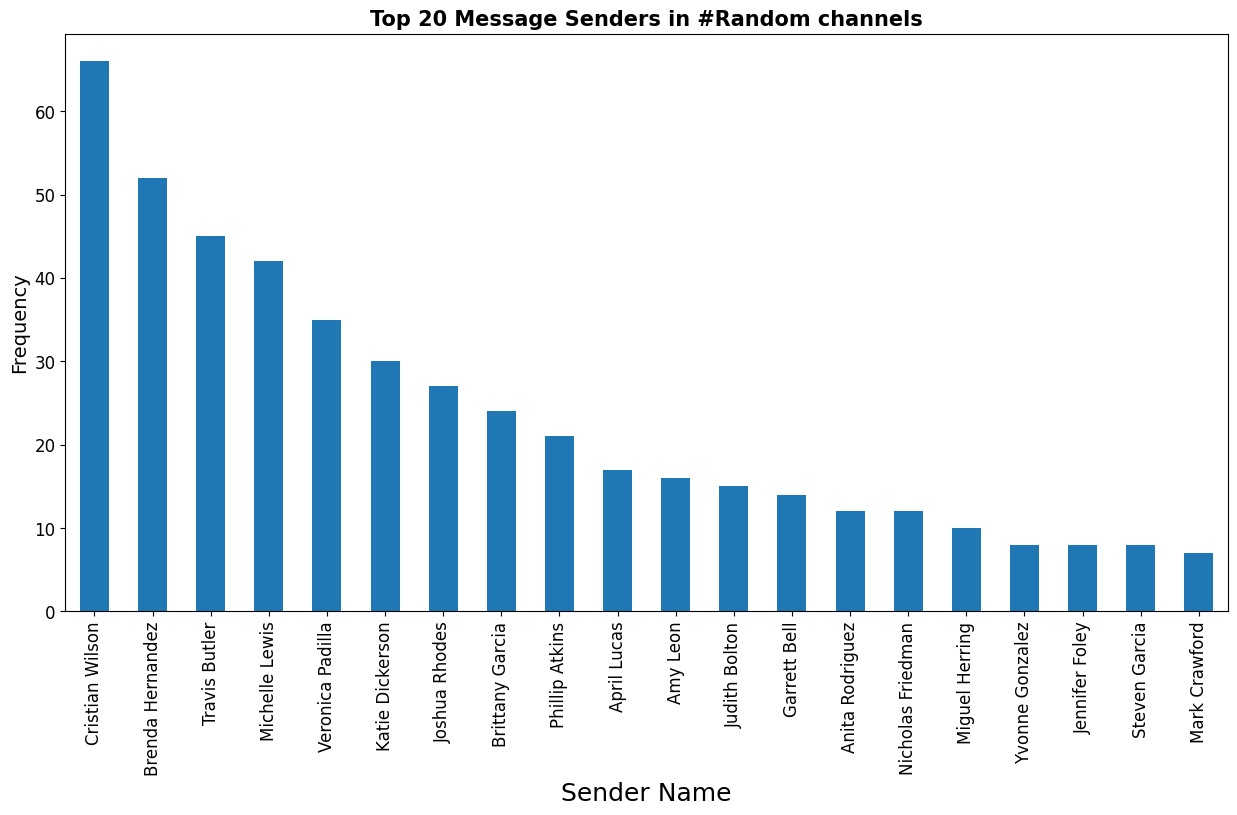

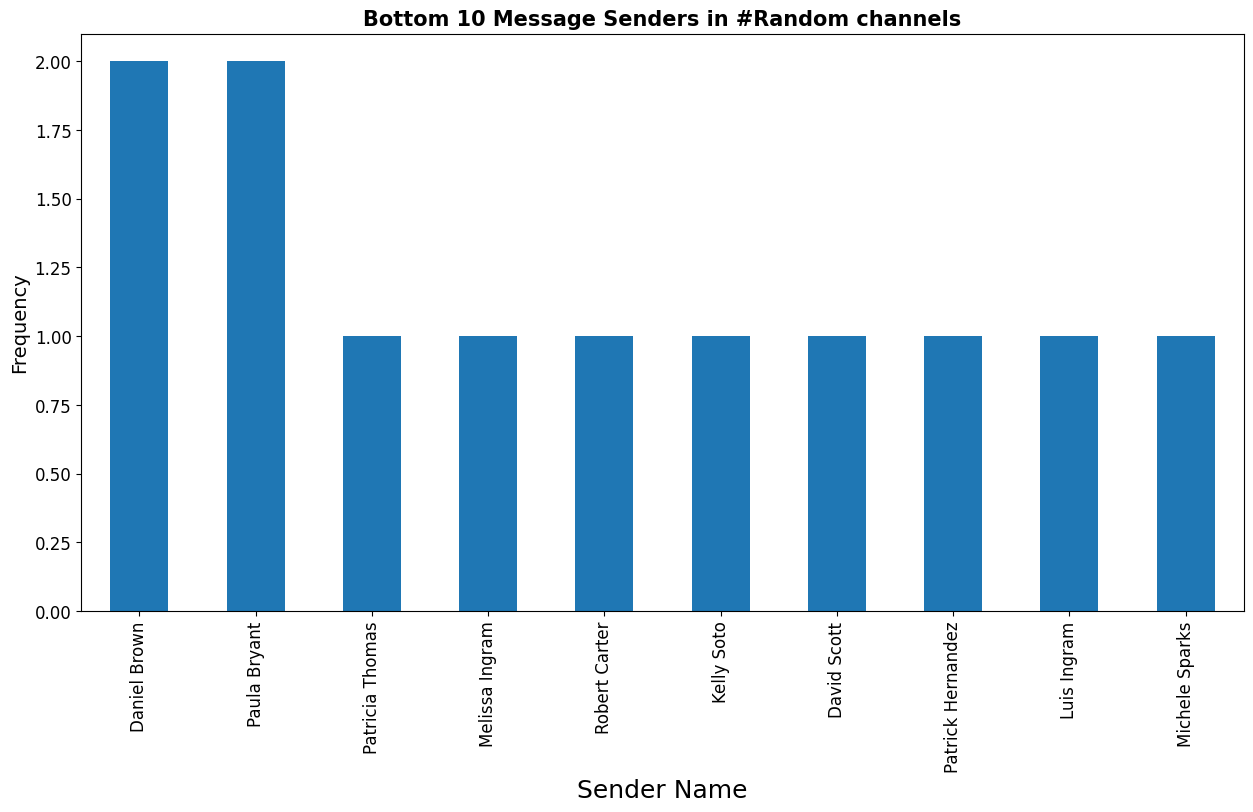

In [17]:
path = 'D:/tenacademy/codes/week0_starter_network_analysis/data/anonymized/all-week1/'
data = slack_parser(path)
get_top_20_user(data)

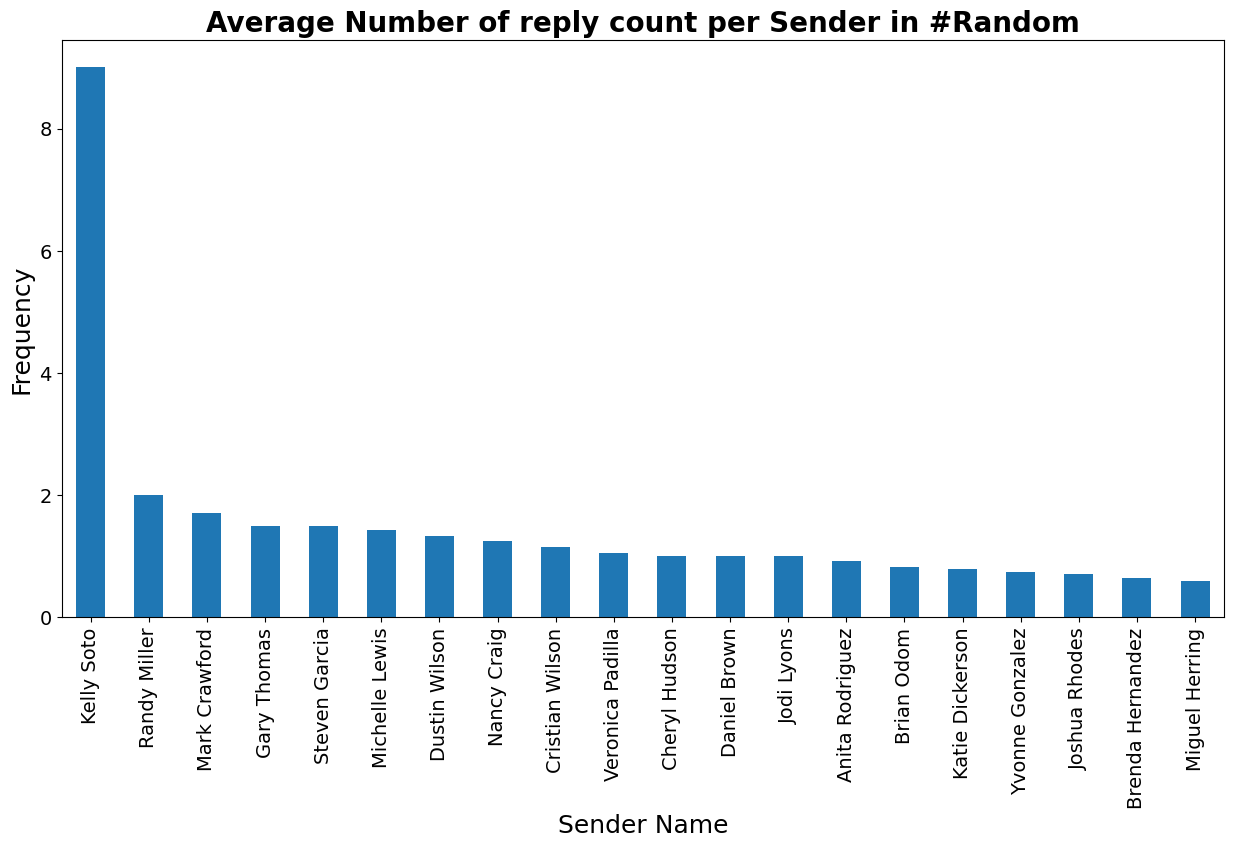

In [18]:
draw_avg_reply_count(data)

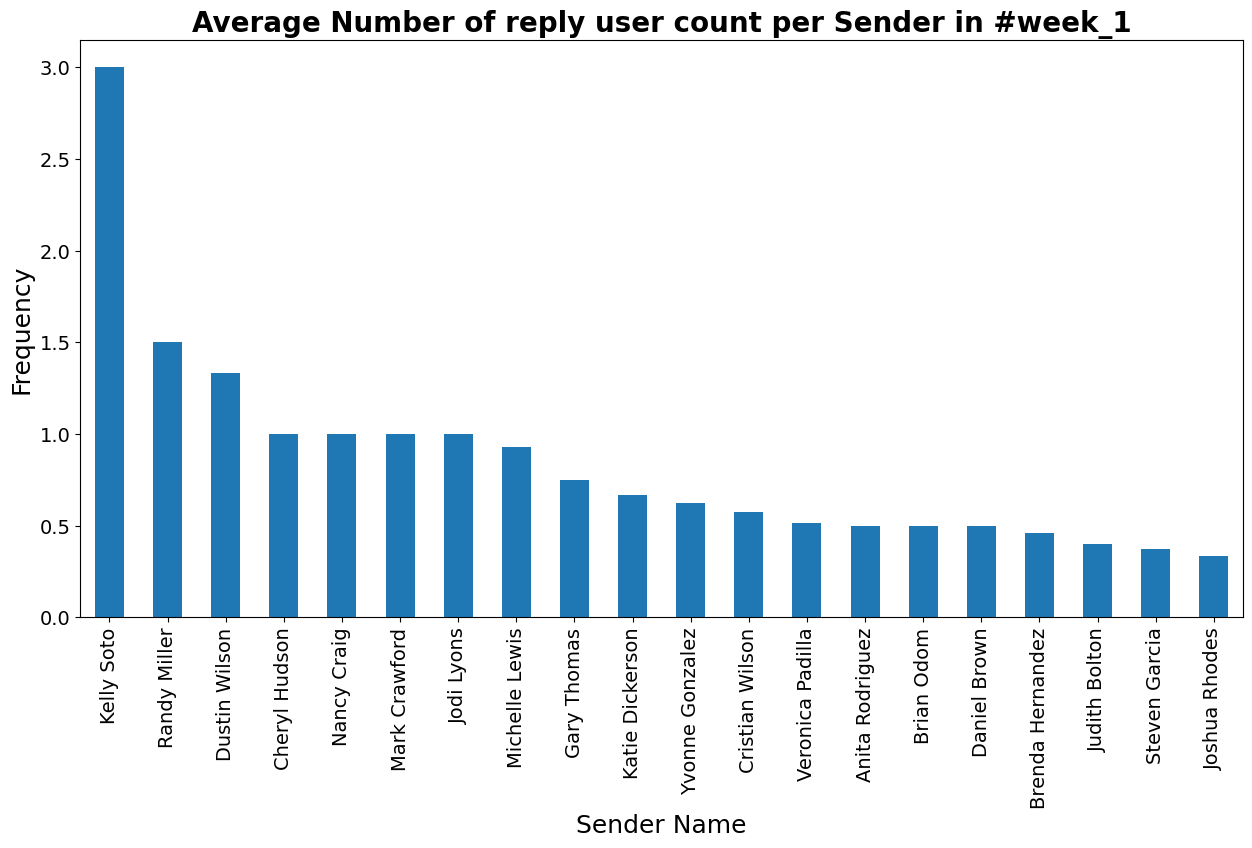

In [19]:
draw_avg_reply_users_count(data,'week_1')

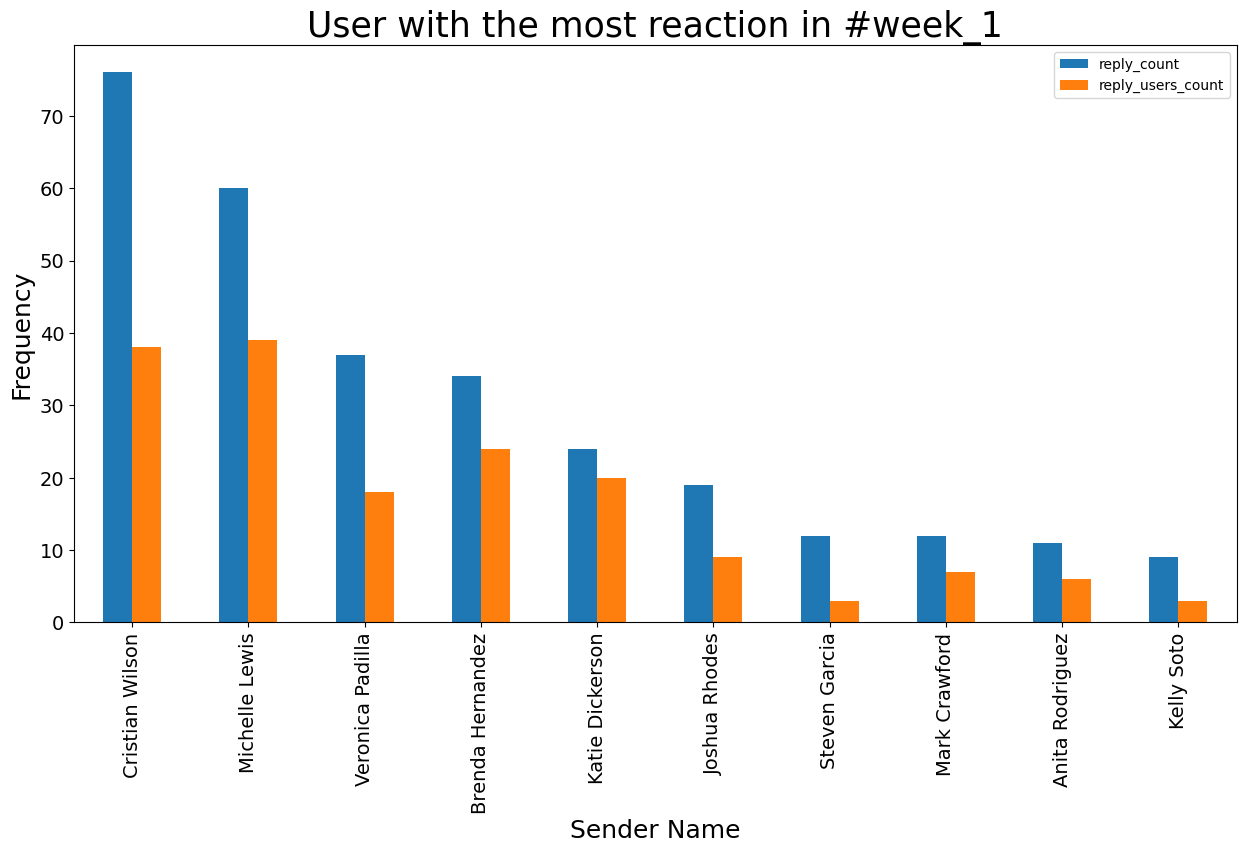

In [20]:
draw_user_reaction(data, 'week_1')

In [21]:
# Which channel has the highest activity? 
# Which channel appears at the right top corner when you plot a 2D scatter plot where x-axis 
# is the number of messages in the channel, y-axis is the sum of number of replies and reactions,
# and the color representing channels?
df = scatter_2d_channels()
df = df.sort_values(by='reactions_replies', ascending=False)
ten_top = df.head(10)
ten_top


,channels,messges,replies,reactions,reactions_replies
4,all-community-building,7613,3652,4550,8202
3,all-career-exercises,782,475,432,907
31,random,581,354,334,688
11,all-week1,551,426,100,526
20,all-week7,456,361,116,477
29,kafka_de,898,390,53,443
18,all-week5,449,341,77,418
2,all-broadcast,537,186,196,382
16,all-week3,387,294,62,356
17,all-week4,290,220,107,327


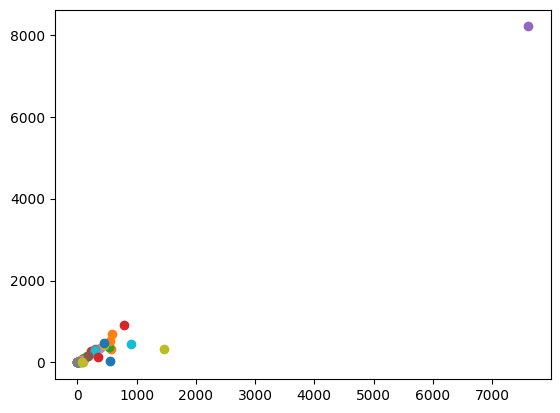

In [22]:
 ##### the  channel appears at the right top corner is all-community-building.
df = scatter_2d_channels()

for channel in df['channels'].unique():
    plt.scatter(df[df['channels'] == channel]['messges'], df[df['channels'] == channel]['reactions_replies'], label=channel)

# plt.title('2D Scatter Plot')
# plt.xlabel('messages')
# plt.ylabel('replies and reactions')
# plt.legend()  # Show legend

# # Add labels to points
# for i, label in enumerate(df['messges']):
#     plt.text(df['messges'][i],  df['reactions_replies'][i], label, rotation=25, fontsize="x-small")

plt.show()

(array([388.,  54.,  37.,  17.,   9.,   3.,   5.,   4.,   8.,   1.,   3.,
          2.,   4.,   2.,   0.,   0.,   1.,   1.,   0.,   1.]),
 array([0.        , 0.14311111, 0.28622222, 0.42933333, 0.57244444,
        0.71555556, 0.85866667, 1.00177778, 1.14488889, 1.288     ,
        1.43111111, 1.57422222, 1.71733333, 1.86044444, 2.00355556,
        2.14666667, 2.28977778, 2.43288889, 2.576     , 2.71911111,
        2.86222222]),
 <BarContainer object of 20 artists>)

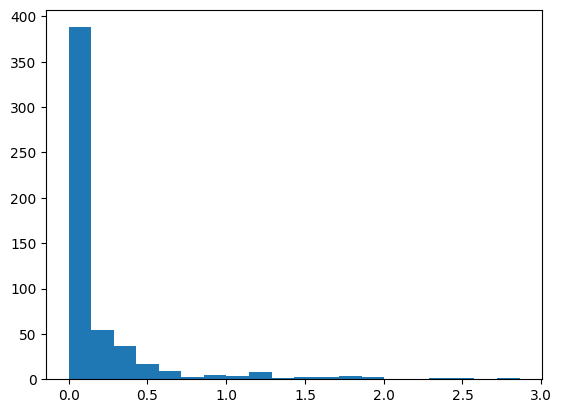

In [46]:
# ######## Task_2 starts here
# What is the distribution of time differences between messages, replies, reactions, and any type event (message, reply, reaction)?

# 1-Plot a histogram of the time difference between Consecutive messages

data = slack_parser(path_channel)
time = convert_2_timestamp('msg_sent_time', data)
data['time'] = time
data['time'] = pd.to_datetime(data['time'])
data['diff'] = data['time'].diff()
data['diff_sec'] = data['diff'].dt.total_seconds()/3600

##### remove the outliers 
data=data.sort_values('diff_sec', ascending = False)
data_remove_outliers = data.iloc[10:]

plt.hist(data_remove_outliers['diff_sec'].dropna(), bins =20)




In [ ]:
2-# 1-Plot a histogram of the time difference between Consecutive replies 



In [ ]:
# Visualize reply counts per user per channel


In [ ]:
# what is the time range of the day that most messages are sent?


In [ ]:
# what kind of messages are replied faster than others?

In [ ]:
# Relationship between # of messages and # of reactions

In [ ]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [ ]:
# Which users got the most reactions?

In [ ]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?